In [1]:
import jax

import jax.numpy as np
import jax.scipy as sp

import scipy as osp
from scipy.stats import kde

import paragami

import matplotlib.pyplot as plt
%matplotlib inline

from bnpmodeling_runjingdev import log_phi_lib, cluster_quantities_lib
import bnpmodeling_runjingdev.functional_sensitivity_lib as func_sens_lib

from structure_vb_lib import structure_model_lib, posterior_quantities_lib
from structure_vb_lib.data_utils import cluster_admix_get_indx

import re
import copy

/accounts/grad/runjing_liu/.conda/envs/bnp_sensitivity_jax/lib/python3.9/site-packages/jax/lib/xla_bridge.py:130: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


In [2]:
import numpy as onp 
onp.random.seed(53453)

# File paths

In [3]:
# data_file='../data/phased_HGDP+India+Africa_2810SNPs-regions1to36.npz'
# out_filename='huang2011_fit'
# out_folder='../fits/hgdp_fits/'

data_file = '../data/huang2011_sub_nobs25_nloci75.npz'
out_filename = 'huang2011_fit_sub'
out_folder = '../fits/tmp/'


In [4]:
alpha0 = 6.0

init_fit_file = out_folder + out_filename + '_alpha' + str(alpha0) + '.npz'
lr_file = out_folder + out_filename + '_alpha' + str(alpha0) + '_lrderivatives.npz'

# Load data

In [5]:
print(data_file)

../data/huang2011_sub_nobs25_nloci75.npz


In [6]:
data = np.load(data_file)
g_obs = np.array(data['g_obs'], dtype = int)

# Load initial fit

In [7]:
print(init_fit_file)

../fits/tmp/huang2011_fit_sub_alpha6.0.npz


In [8]:
vb_init_dict, vb_params_paragami, _, _, \
    gh_loc, gh_weights, init_fit_meta_data = \
        structure_model_lib.load_structure_fit(init_fit_file)

In [9]:
vb_init_free = vb_params_paragami.flatten(vb_init_dict, free = True)

# Function to load vb parameters

Loads parameters from both refit and LR

In [10]:
def get_free_param_array(perturbation, delta):     
    
    #################
    # load linear response derivatives
    #################
    # print('loading derivatives from: ', lr_file)
    lr_data = np.load(lr_file)
    assert lr_data['alpha0'] == alpha0
    assert np.abs(lr_data['vb_opt'] - vb_init_free).max() < 1e-12
    assert np.abs(lr_data['kl'] - init_fit_meta_data['final_kl']) < 1e-8
    
    print('Derivative time: {:.3f}secs'.format(lr_data['lr_time_' + perturbation]))
    print('CG tolerance: ', lr_data['cg_tol'])
    
    ##################
    # load refit results
    ##################
    # get all files for that particular perturbation
    match_crit = out_filename + '_' + perturbation + '_delta{}_eps'.format(delta) + '\d+.npz'
    refit_files = [f for f in os.listdir(out_folder) if re.match(match_crit, f)]
    
    assert len(refit_files) > 0, 'no refit files found'
    
    # load files
    optim_time_vec = [init_fit_meta_data['optim_time']]
    epsilon_vec = [0.]
    vb_refit_list = [vb_init_free]

    for i in range(len(refit_files)): 

        # print('loading fit from: ', refit_files[i])
        vb_params_dict, vb_params_paragami, meta_data = \
            paragami.load_folded(out_folder + refit_files[i])
        
        optim_time_vec.append(meta_data['optim_time'])
        epsilon_vec.append(meta_data['epsilon'])
        vb_refit_list.append(vb_params_paragami.flatten(vb_params_dict, free = True))
        assert meta_data['delta'] == delta
        
    optim_time_vec = np.array(optim_time_vec)
    epsilon_vec = np.array(epsilon_vec)
    vb_refit_list = np.array(vb_refit_list)
    
    # sort the epsilons 
    _indx = np.argsort(epsilon_vec)
    optim_time_vec = optim_time_vec[_indx]
    epsilon_vec = epsilon_vec[_indx]
    vb_refit_list = vb_refit_list[_indx]
    
    print('Optim time at epsilon = 1: {:.3f}secs'.format(optim_time_vec[-1]))
    
    ###############
    # get linear response predictions 
    ###############
    def predict_opt_par_from_hyper_par(epsilon): 
        return vb_init_free + lr_data['dinput_dfun_' + perturbation] * epsilon * delta
    
    lr_list = []
    for epsilon in epsilon_vec: 
        # get linear response
        lr_list.append(predict_opt_par_from_hyper_par(epsilon))
    
    return vb_refit_list, np.array(lr_list), epsilon_vec

# Function to make plots

In [11]:
def print_diff_plot(refit, lr, init, title = '', alpha = 0.05): 
    
    fig, ax = plt.subplots(1, 2, figsize = (10, 4)) 

    diff_refit = refit - init
    diff_lr = lr - init
    
    ####################
    # scatter plot
    ####################
    ax[0].scatter(diff_refit, 
               diff_lr, 
               marker = 'o', 
               color = 'red', 
               alpha = alpha)   
    ax[0].set_xlabel('refit - init')
    ax[0].set_ylabel('lr - init')   
    # x = y line
    ax[0].plot(diff_refit, diff_refit, '-', color = 'blue')
    ax[0].set_title(title)
    
    ####################
    # Draw contours
    ####################
    nbins = 20
    x, y = diff_refit, diff_lr
    gauss_kde = kde.gaussian_kde(np.array([x, y]))
    xi, yi = onp.mgrid[x.min():x.max():nbins*1j, y.min():y.max():nbins*1j]
    zi = gauss_kde(np.vstack([xi.flatten(), yi.flatten()]))
    zi = (zi - zi.min()) / (zi.max() - zi.min())
    ax[0].contour(xi, yi, zi.reshape(xi.shape), 
                  levels = [0.001, 0.01, 0.1], 
                colors = 'grey')

    
    ##########################
    # compute some statistics for the diff plot
    # this is hacky ... replace with ax.table at some point
    
    # Hide axes
    ax[1].xaxis.set_visible(False) 
    ax[1].yaxis.set_visible(False)
    
    # mae 
    mean_ae = np.abs(refit - lr).mean()
    med_ae = np.median(np.abs(refit - lr))
    ax[1].text(0.05, 0.9, 
               'mean absolute error: {:.03f}'.format(mean_ae),
               fontsize=15)
    ax[1].text(0.05, 0.8, 
               'median absolute error: {:.03f}'.format(med_ae),
               fontsize=15)
    
    # R2 
    r_value = osp.stats.linregress(diff_refit,
                                   diff_lr).rvalue
    
    my_filter = (np.abs(diff_lr) < diff_refit.max()) & \
                    (np.abs(diff_lr) > diff_refit.min()) 
    r_value_filtered = osp.stats.linregress(diff_refit[my_filter],
                                            diff_lr[my_filter]).rvalue
    ax[1].text(0.05, 0.7, 
               'R2: {:.03f}'.format(r_value),
               fontsize=15)
    ax[1].text(0.05, 0.6, 
               'R2 (filtered): {:.03f}'.format(r_value_filtered),
               fontsize=15)
    # proportion that had the correct sign 
    sign_correct = np.mean(np.sign(diff_refit) == np.sign(diff_lr))
    ax[1].text(0.05, 0.5, 
               'propn sign correct:  {:.03f}'.format(sign_correct),
               fontsize=15)

### Plot individual admixtures

In [12]:
def get_e_ind_admix(vb_free_params): 
    
    # this returns the expected individual mixture proportions. 
        
    vb_params_dict = vb_params_paragami.fold(vb_free_params, free = True)
    
    stick_means = vb_params_dict['ind_admix_params']['stick_means']
    stick_infos = vb_params_dict['ind_admix_params']['stick_infos']
    
    e_ind_admix = cluster_quantities_lib.get_e_cluster_probabilities(stick_means, 
                                                                     stick_infos, 
                                                                     gh_loc, 
                                                                     gh_weights)
    return e_ind_admix

In [13]:
def plot_colormaps(refit_matr, lr_matr, init_matr, fig, ax): 
    # plot initial 
    ax[0].set_title('initial')
    im0 = ax[0].matshow(init_matr, 
                        cmap = plt.get_cmap('Blues'))
    fig.colorbar(im0, ax = ax[0])
    
    # plot refit - initial 
    diff_refit = refit_matr - init_matr
    
    # set the vmax 
    vmax = 2 * np.abs(diff_refit).max()
    ax[1].set_title('refit - init')
    im1 = ax[1].matshow(diff_refit, 
                        vmax = vmax,
                        vmin = -vmax, 
                        cmap = plt.get_cmap('bwr'))
    # fig.colorbar(im1, ax = ax[1])
    
    # plot lr - initial
    ax[2].set_title('lr - init')
    diff_lr = lr_matr - init_matr
    # set colors outside vmax to be grey 
    cmap = copy.copy(plt.get_cmap('bwr'))
    cmap.set_over('grey')
    cmap.set_under('grey')
    im2 = ax[2].matshow(diff_lr,
                        vmax = vmax,
                        vmin = -vmax,
                        cmap = cmap)
    fig.colorbar(im2, ax = ax[2])

In [14]:
def plot_mixture_proportions(e_ind_admix_refit, e_ind_admix_lr, e_ind_admix_init): 
    
    fig, ax = plt.subplots(1, 3, figsize = (10, 5))
    
    plot_colormaps(e_ind_admix_refit, e_ind_admix_lr, e_ind_admix_init, fig, ax)
    
    for a in ax: 
        a.xaxis.set_ticks_position('bottom')

### Plot co-clustering

In [15]:
def plot_coclustering(e_ind_admix_refit, e_ind_admix_lr, e_ind_admix_init): 
    
    fig, ax = plt.subplots(1, 3, figsize = (12, 3))
    
    # cluster the initial fit 
    indx = cluster_admix_get_indx(e_ind_admix_init)

    # compute co-clustering matrix 
    coclust_init = np.dot(e_ind_admix_init[indx], 
                          e_ind_admix_init[indx].transpose())
    coclust_refit = np.dot(e_ind_admix_refit[indx],
                           e_ind_admix_refit[indx].transpose())
    coclust_lr = np.dot(e_ind_admix_lr[indx],
                        e_ind_admix_lr[indx].transpose())
    
    plot_colormaps(coclust_refit, coclust_lr, coclust_init, fig, ax)
        
    return coclust_refit, coclust_lr, coclust_init

### Function to plot all results

In [16]:
def plot_results_for_perturbation(perturbation, delta): 
    #################
    # load free parameters
    #################
    vb_refit_list, lr_list, epsilon_vec = \
        get_free_param_array(perturbation, delta)

    #################
    # compute mixture proportions
    #################
    e_ind_admix_init = get_e_ind_admix(vb_init_free)
    e_ind_admix_refit = get_e_ind_admix(vb_refit_list[-1])
    e_ind_admix_lr = get_e_ind_admix(lr_list[-1])

    #################
    # subsample
    #################
    # subsampled individuals
    n_obs = e_ind_admix_init.shape[0]
    if n_obs > 25: 
        n_indx = onp.random.choice(n_obs, 25)
        n_indx = np.sort(n_indx)
    else: 
        n_indx = np.arange(25)
        
    # choose the important k: 
    # pick the first 7 clusters, and last cluster
    k_approx = e_ind_admix_init.shape[-1]
    k_indx = onp.arange(8)
    k_indx[-1] = k_approx - 1
        
    e_ind_admix_init_sub = e_ind_admix_init[n_indx][:, k_indx]
    e_ind_admix_refit_sub = e_ind_admix_refit[n_indx][:, k_indx]
    e_ind_admix_lr_sub = e_ind_admix_lr[n_indx][:, k_indx]
    
    #################
    # Plot mixture proportions
    #################
    plot_mixture_proportions(e_ind_admix_refit_sub,
                             e_ind_admix_lr_sub, 
                             e_ind_admix_init_sub)
    
    #################
    # compare differences
    #################
    print_diff_plot(e_ind_admix_refit[:, 0:6].flatten(), 
                    e_ind_admix_lr[:, 0:6].flatten(), 
                    e_ind_admix_init[:, 0:6].flatten(), 
                    title = 'diff in individual admixtures for first 6 clusters')
    
    #################
    # Plot coclustering
    #################
    coclust_refit, coclust_lr, coclust_init = \
        plot_coclustering(e_ind_admix_refit,
                          e_ind_admix_lr, 
                          e_ind_admix_init)
    
    print_diff_plot(coclust_refit.flatten(), 
                    coclust_lr.flatten(), 
                    coclust_init.flatten(), 
                    title = 'diff in co-clustering')

### Function to plot perturbation

In [17]:
def plot_perturbation(perturbation, delta): 
        
    lr_data = np.load(lr_file)
    alpha0 = lr_data['alpha0']
    
    # get functional perturbation objectives
    # a lot of arguments are "none" because we just 
    # need the bare minimum to make plots
    f_obj_all = log_phi_lib.LogPhiPerturbations(vb_params_paragami = None, 
                                                 alpha0 = alpha0,
                                                 gh_loc = None, 
                                                 gh_weights = None,
                                                 logit_v_grid = None, 
                                                 influence_grid = None, 
                                                 delta = delta,
                                                 stick_key = 'ind_admix_params')

    f_obj = getattr(f_obj_all, 'f_obj_' + perturbation)
    
    # compute the prior perturbations
    prior_perturbation = func_sens_lib.PriorPerturbation(
                                    alpha0 = alpha0,
                                    log_phi = f_obj.log_phi, 
                                    logit_v_ub = 10, 
                                    logit_v_lb = -10)
    
    prior_perturbation.plot_perturbation();
    
    return prior_perturbation

# Plot results

In [18]:
# perturbation = 'worst_case'
# plot_perturbation(perturbation)
# plot_results_for_perturbation(perturbation)

# Sigmoidal perturbations

/accounts/grad/runjing_liu/.conda/envs/bnp_sensitivity_jax/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:259: AccuracyWarning: maxiter (50) exceeded. Latest difference = 9.388126e-08
  warnings.warn(


Derivative time: 0.221secs
CG tolerance:  0.01
Optim time at epsilon = 1: 6.794secs


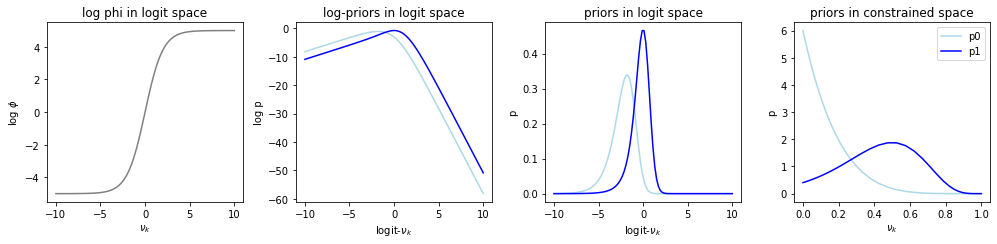

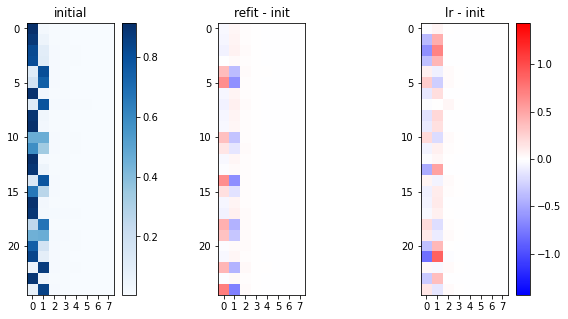

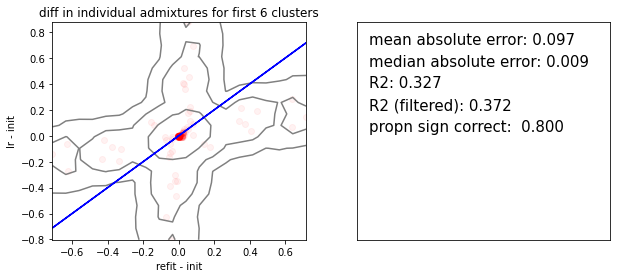

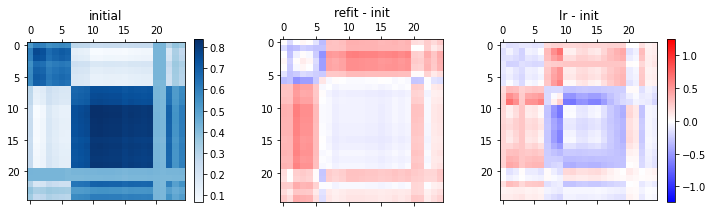

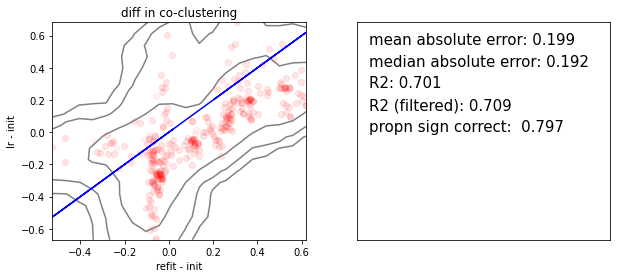

In [19]:
perturbation = 'sigmoidal'
plot_perturbation(perturbation, delta = 5)
plot_results_for_perturbation(perturbation, delta = 5)

Derivative time: 0.221secs
CG tolerance:  0.01
Optim time at epsilon = 1: 6.509secs


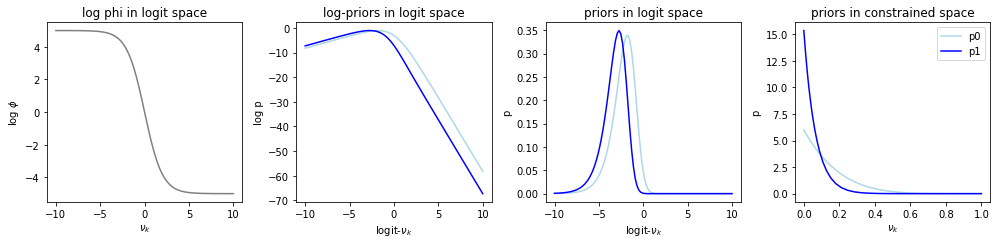

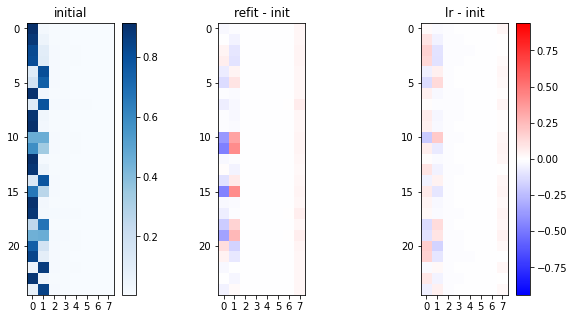

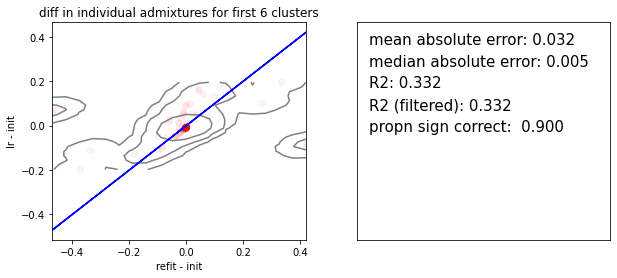

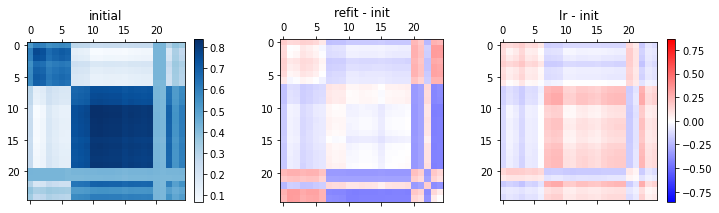

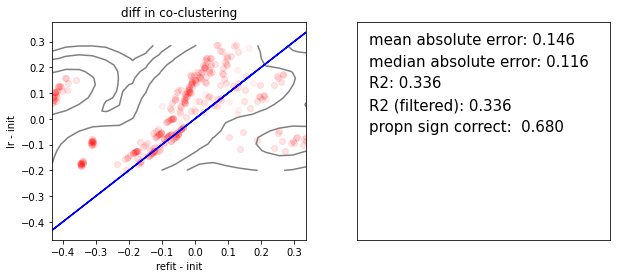

In [20]:
perturbation = 'sigmoidal'
plot_perturbation(perturbation, delta = -5)
plot_results_for_perturbation(perturbation, delta = -5)

# Perturbations corresponding to moving \alpha

Derivative time: 0.151secs
CG tolerance:  0.01
Optim time at epsilon = 1: 10.356secs


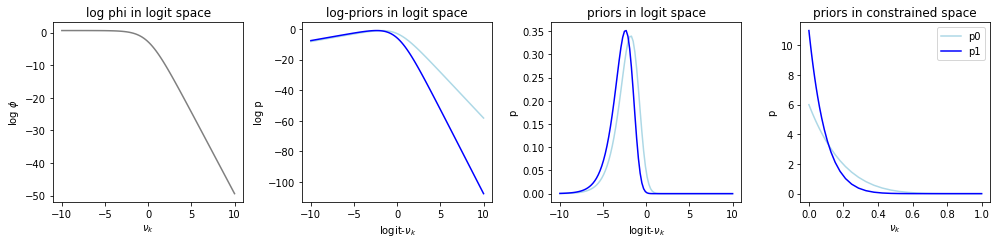

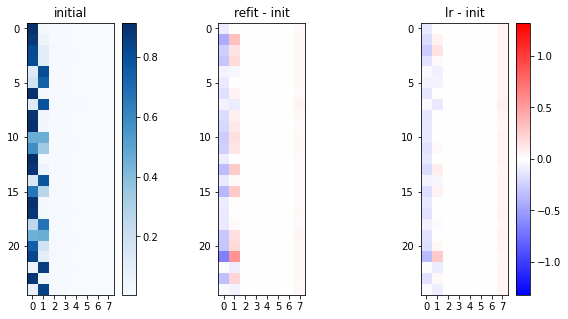

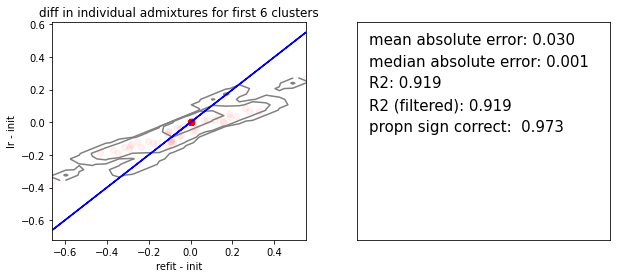

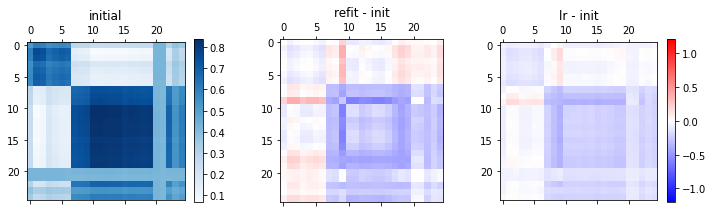

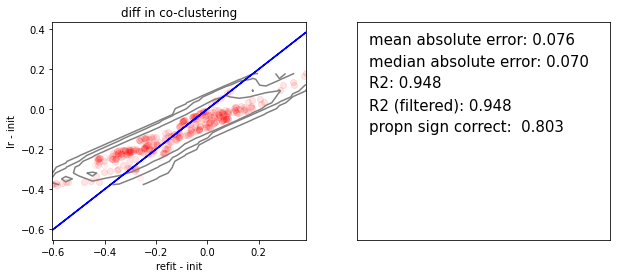

In [21]:
perturbation = 'alpha_pert_pos'
plot_perturbation(perturbation, delta = 1)
plot_results_for_perturbation(perturbation, delta = 1)

Derivative time: 0.151secs
CG tolerance:  0.01
Optim time at epsilon = 1: 7.994secs


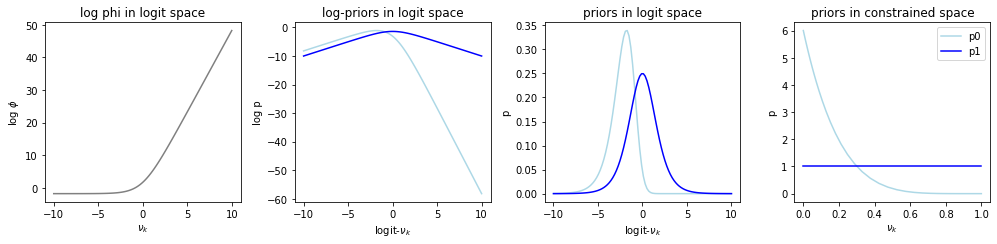

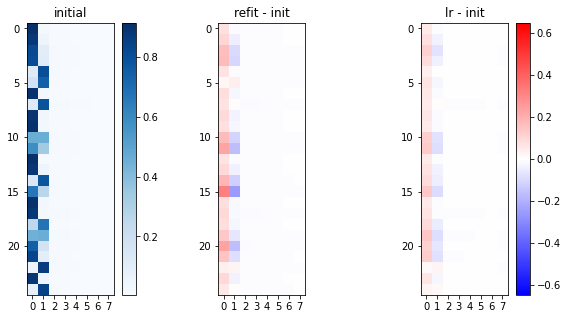

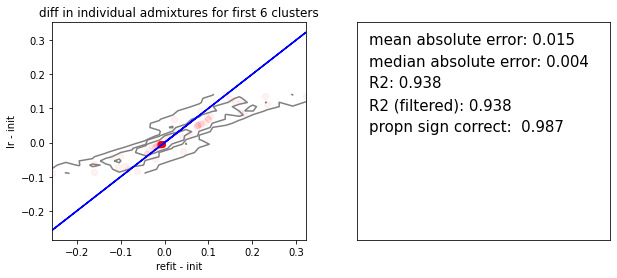

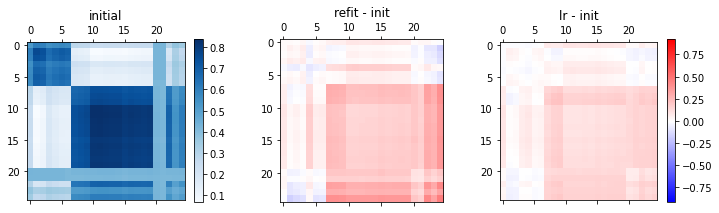

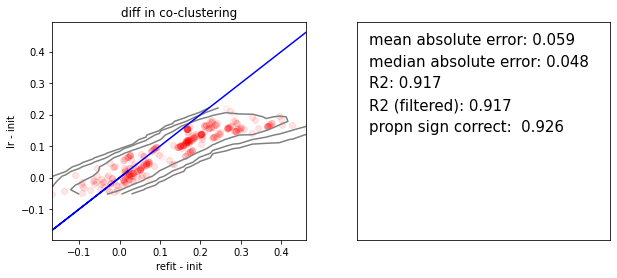

In [22]:
perturbation = 'alpha_pert_neg'
plot_perturbation(perturbation, delta = 1)
plot_results_for_perturbation(perturbation, delta = 1)

/accounts/grad/runjing_liu/.conda/envs/bnp_sensitivity_jax/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:259: AccuracyWarning: maxiter (50) exceeded. Latest difference = 3.091946e-08
  warnings.warn(


Derivative time: 0.143secs
CG tolerance:  0.01
Optim time at epsilon = 1: 11.151secs


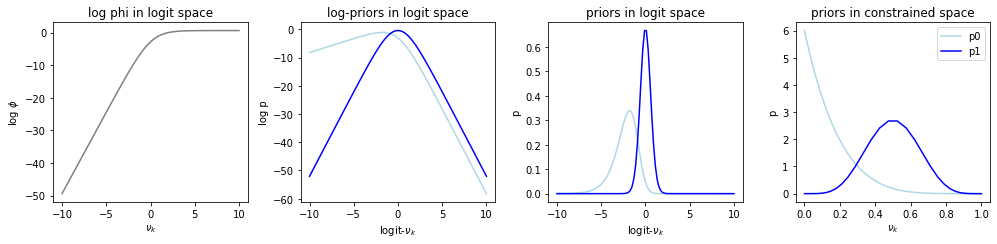

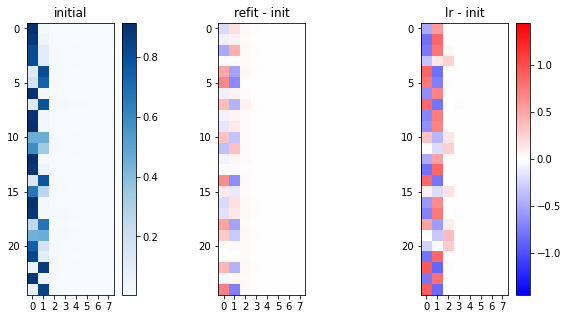

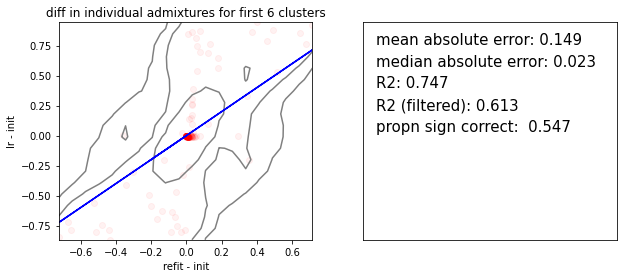

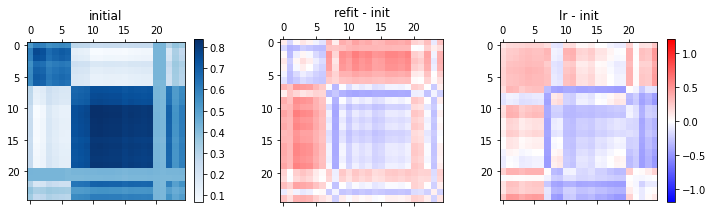

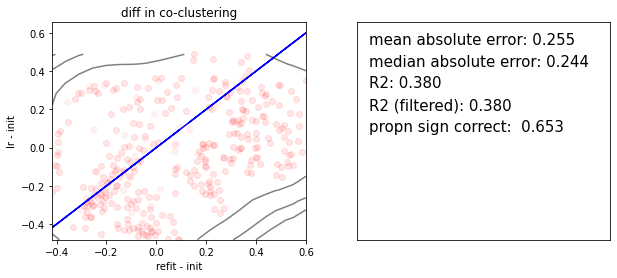

In [23]:
perturbation = 'alpha_pert_pos_xflip'
plot_perturbation(perturbation, delta = 1)
plot_results_for_perturbation(perturbation, delta = 1)

In [24]:
# perturbation = 'alpha_pert_neg_xflip'
# plot_perturbation(perturbation)
# plot_results_for_perturbation(perturbation)

# Gaussian perturbations

/accounts/grad/runjing_liu/.conda/envs/bnp_sensitivity_jax/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:259: AccuracyWarning: maxiter (50) exceeded. Latest difference = 3.227507e-06
  warnings.warn(


Derivative time: 0.213secs
CG tolerance:  0.01
Optim time at epsilon = 1: 6.162secs


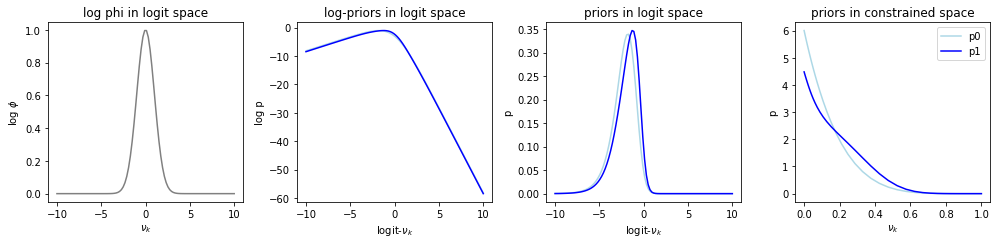

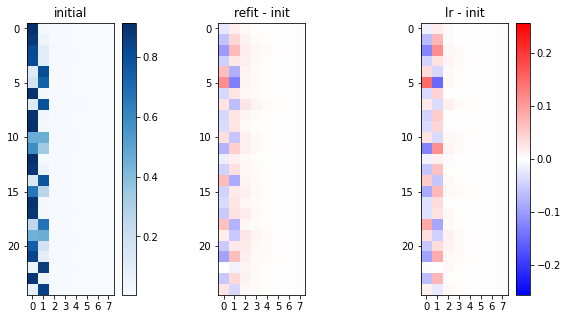

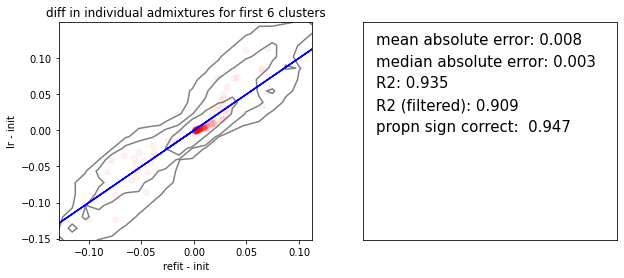

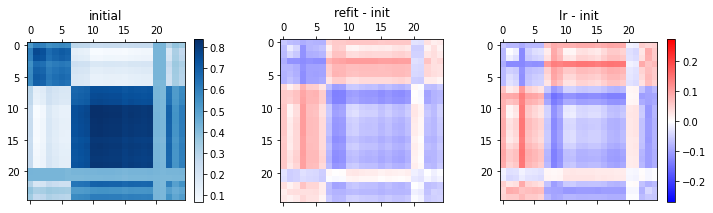

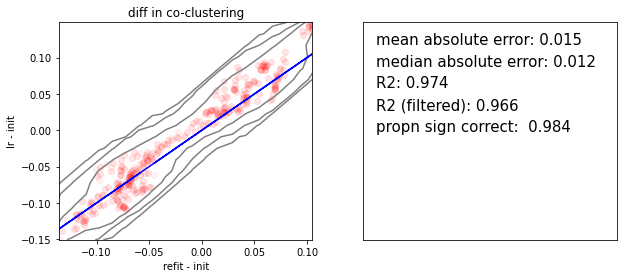

In [25]:
perturbation = 'gauss_pert1'
plot_perturbation(perturbation, delta = 1)
plot_results_for_perturbation(perturbation, delta = 1)

/accounts/grad/runjing_liu/.conda/envs/bnp_sensitivity_jax/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:259: AccuracyWarning: maxiter (50) exceeded. Latest difference = 7.001209e-08
  warnings.warn(


Derivative time: 0.213secs
CG tolerance:  0.01
Optim time at epsilon = 1: 8.136secs


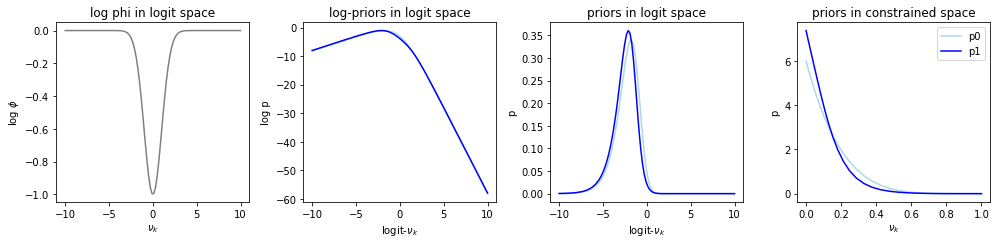

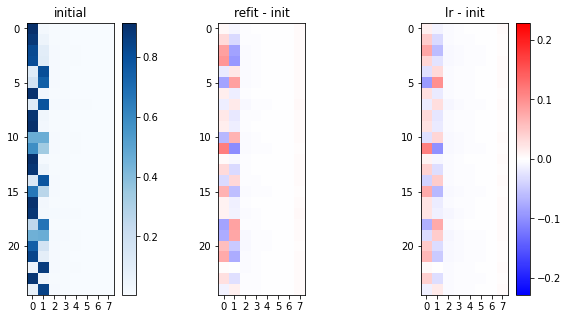

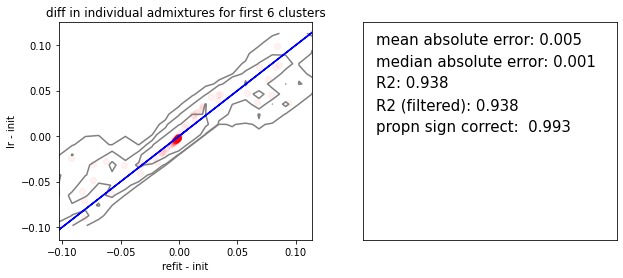

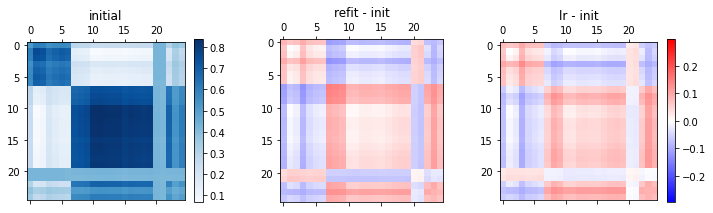

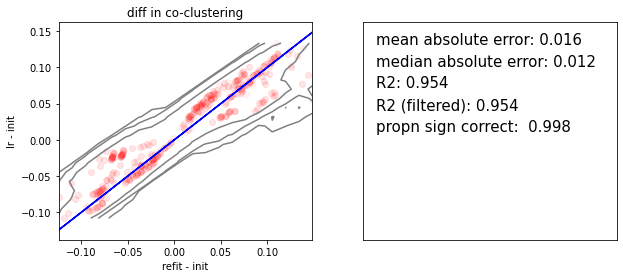

In [26]:
perturbation = 'gauss_pert1'
delta = -1
plot_perturbation(perturbation, delta = -1)
plot_results_for_perturbation(perturbation, delta = -1)

/accounts/grad/runjing_liu/.conda/envs/bnp_sensitivity_jax/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:259: AccuracyWarning: maxiter (50) exceeded. Latest difference = 7.412626e-07
  warnings.warn(


Derivative time: 0.213secs
CG tolerance:  0.01
Optim time at epsilon = 1: 5.434secs


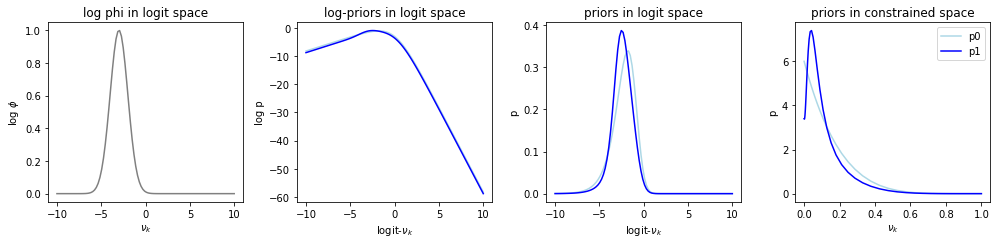

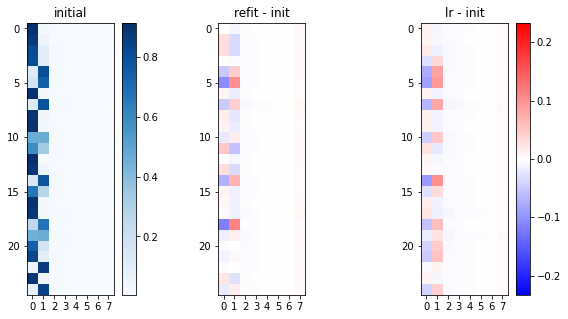

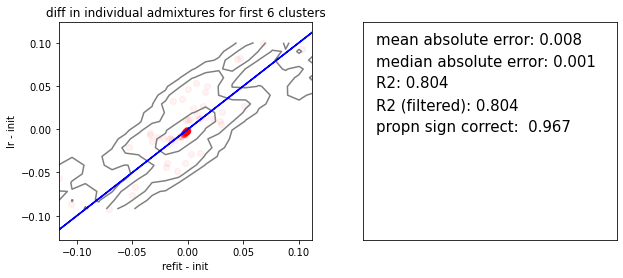

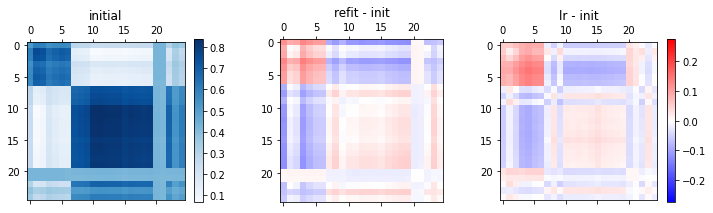

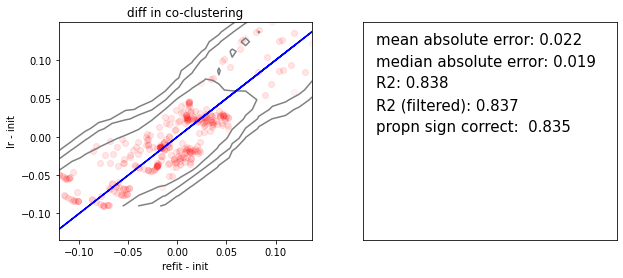

In [27]:
perturbation = 'gauss_pert2'
plot_perturbation(perturbation, delta = 1)
plot_results_for_perturbation(perturbation, delta = 1)

/accounts/grad/runjing_liu/.conda/envs/bnp_sensitivity_jax/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:259: AccuracyWarning: maxiter (50) exceeded. Latest difference = 2.524900e-08
  warnings.warn(


Derivative time: 0.213secs
CG tolerance:  0.01
Optim time at epsilon = 1: 4.115secs


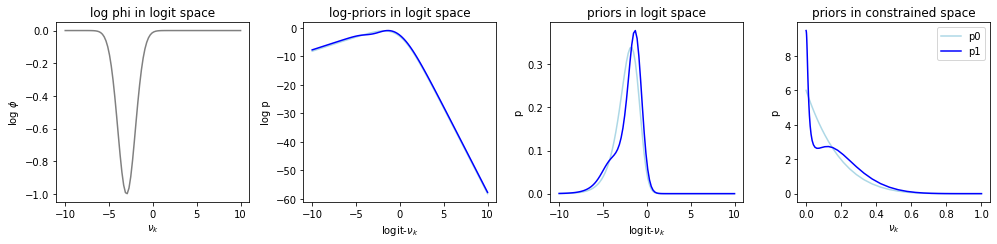

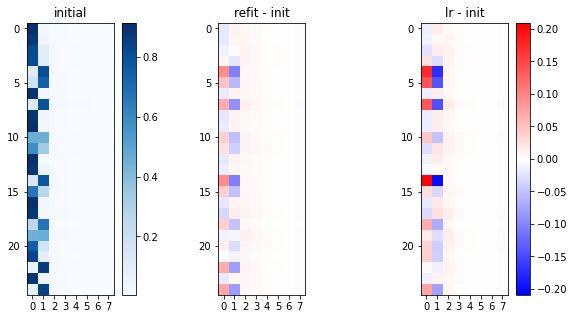

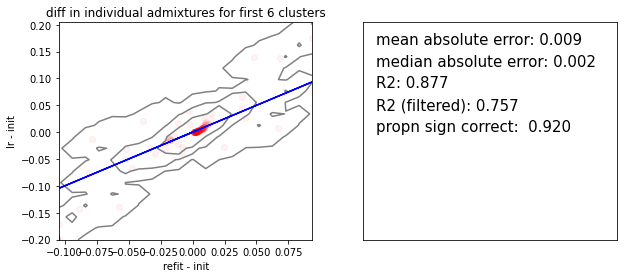

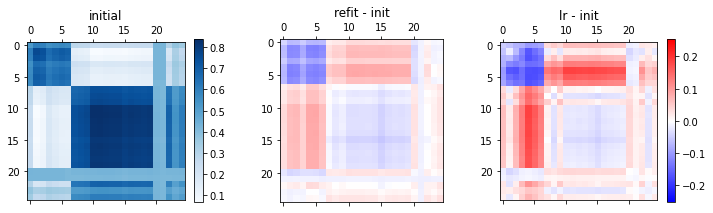

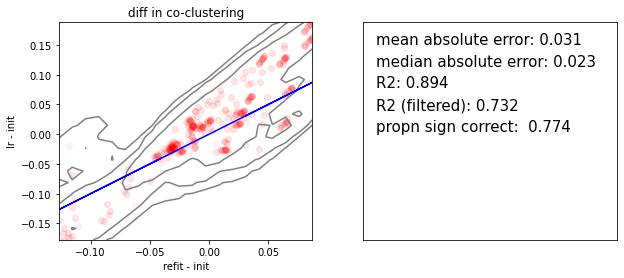

In [28]:
perturbation = 'gauss_pert2'
plot_perturbation(perturbation, delta = -1)
plot_results_for_perturbation(perturbation, delta = -1)